 Drowsiness Detection Model Prediction - For a image:
 Steps involved to extract drowsiness indication for eyes and mouth

 1. Detect face from image using MTCNN
 2. Crop face region to neglect background
 3. Crop left and right eye region using haarcascade library
 4. Crop mouth region from the image
 5. Predict probabilty of a person eye - Closed/Open, yawn/no-yawn using loaded_model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from keras.models import load_model
import tensorflow as tf
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/drowsy_detection/vggRetrain/vgg16Retrain_5epoch')

In [ ]:
with open("/content/gdrive/MyDrive/drowsy_detection/vggModelDump", "w") as model_save_file:
    model_json = new_model.to_json()
    model_save_file.write(model_json)

# save model weights
new_model.save_weights("/content/gdrive/MyDrive/drowsy_detection/vgg16weights")


In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [ ]:
class_names = {'Closed': 0, 'Open': 1, 'no_yawn': 2, 'yawn': 3}


In [ ]:
import cv2
eyeCascade = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_eye.xml")
leyeCascade = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_lefteye_2splits.xml")
reyeCascade = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_righteye_2splits.xml")
mouthCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')


In [ ]:
import os
cv2_base_dir = os.path.dirname(os.path.abspath(cv2.__file__))
dir_list = os.listdir(cv2_base_dir)

In [ ]:
cv2_base_dir

'/usr/local/lib/python3.7/dist-packages/cv2'

In [ ]:
dir_list

['data',
 'misc',
 'gapi',
 'config.py',
 'LICENSE-3RD-PARTY.txt',
 'version.py',
 'LICENSE.txt',
 '__pycache__',
 'cv2.abi3.so',
 'utils',
 'qt',
 'load_config_py3.py',
 'mat_wrapper',
 'load_config_py2.py',
 '__init__.py',
 'config-3.py']

In [ ]:
reversed_dictionary = dict(map(reversed, class_names.items()))

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import image
import os
from mtcnn import MTCNN


In [ ]:
def detect_faces_from_img(filename):
    pixels = plt.imread(filename)
    detector = mtcnn.MTCNN()
    faces = detector.detect_faces(pixels)
    return faces[0]

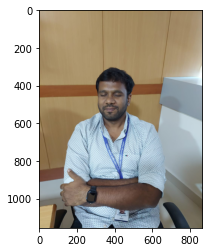

In [ ]:
# Full image shown -
pixels = plt.imread("/content/gdrive/MyDrive/drowsy_detection/test_images/test_sleep_new.jpg")
plt.imshow(pixels)

In [ ]:
face= detect_faces_from_img("/content/gdrive/MyDrive/drowsy_detection/test_images/test_sleep_new.jpg")


In [ ]:
def crop_faces(face,filename):
  img = cv2.imread(filename)
  x, y, w, h = face['box']
  crop = img[y:y+h, x:x+w]
  plt.imshow(crop)
  return crop


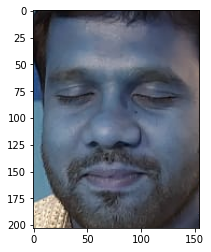

In [ ]:
crop_img = crop_faces(face,"/content/gdrive/MyDrive/drowsy_detection/test_images/test_sleep_new.jpg")

In [ ]:
def get_left_eye_region(face,filename):
  crop_img = crop_faces(face,filename)
  crop_img = cv2.cvtColor(crop_img,cv2.COLOR_BGR2RGB)
  imageCrop = np.expand_dims(crop_img, axis=0)
  imageCrop = preprocess_input(crop_img)
  geteye=leyeCascade.detectMultiScale(crop_img,scaleFactor = 1.1, minNeighbors = 4)
  gozler=[]

  for (x,y,w,h) in geteye:
      gozler.append(crop_img[y:y+h, x:x+w])
  try:
    imageEye = Image.fromarray(gozler[0].astype(np.uint8))
    print("Left eye:")
    plt.imshow(imageEye)

  except:
    imageEye=Image.fromarray(crop_img.astype(np.uint8))
    print("File with no left eye region "+ filename)
  return imageEye



Left eye:


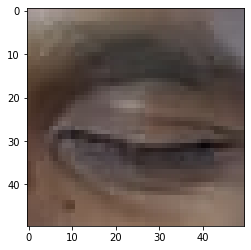

In [ ]:
imageLeftEye = get_left_eye_region(face,"/content/gdrive/MyDrive/drowsy_detection/test_images/test_sleep_new.jpg")

In [ ]:
def get_right_eye_region(face,filename):
  crop_img = crop_faces(face,filename)
  crop_img = cv2.cvtColor(crop_img,cv2.COLOR_BGR2RGB)
  imageCrop = np.expand_dims(crop_img, axis=0)
  imageCrop = preprocess_input(crop_img)
  geteye=reyeCascade.detectMultiScale(crop_img,scaleFactor = 1.1, minNeighbors = 4)
  gozler=[]

  for (x,y,w,h) in geteye:
      gozler.append(crop_img[y:y+h, x:x+w])
  try:
    imageEye = Image.fromarray(gozler[0].astype(np.uint8))
    print("Right eye:")
    plt.imshow(imageEye)

  except:
    imageEye=Image.fromarray(crop_img.astype(np.uint8))
    print("File with no Right eye region "+ filename)
  return imageEye


Right eye:


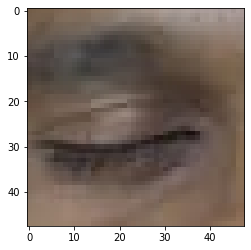

In [ ]:
imageRightEye = get_right_eye_region(face,"/content/gdrive/MyDrive/drowsy_detection/test_images/test_sleep_new.jpg")

In [ ]:
def get_prediction_eye(imageEye,imageRtEye,new_model):
  imageEye = imageEye.resize((256, 256), Image.BILINEAR)
  x = image.img_to_array(imageEye)
  # Adding the fouth dimension, for number of images
  x = np.expand_dims(x, axis=0)
  imageEye = preprocess_input(x)
  predictions=new_model.predict(imageEye)
  imageRtEye = imageRtEye.resize((256, 256), Image.BILINEAR)
  xRt = image.img_to_array(imageRtEye)
  xRt = np.expand_dims(xRt,axis=0)
  imageRtEye = preprocess_input(xRt)
  predRtEye = new_model.predict(imageRtEye)
  return reversed_dictionary.get(np.argmax(predictions)), reversed_dictionary.get(np.argmax(predRtEye))

In [ ]:
result1,result2 = get_prediction_eye(imageLeftEye,imageRightEye,new_model)

In [ ]:
result1,result2

('Closed', 'Closed')

In [ ]:
def get_mouth_region(face,filename):
  crop_img = crop_faces(face,filename)
  crop_img = cv2.cvtColor(crop_img,cv2.COLOR_BGR2RGB)
  imageCrop = np.expand_dims(crop_img, axis=0)
  imageCrop = preprocess_input(crop_img)
  getmouth= mouthCascade.detectMultiScale(crop_img,scaleFactor = 1.7, minNeighbors = 5)
  gozler=[]

  for (x,y,w,h) in getmouth:
      gozler.append(crop_img[y:y+h, x:x+w])
  try:
    imageMouth = Image.fromarray(gozler[0].astype(np.uint8))
    print("Mouth:")
    plt.imshow(imageMouth)

  except:
    imageMouth=Image.fromarray(crop_img.astype(np.uint8))
    print("File with no Mouth region "+ filename)
  return imageMouth


Mouth:


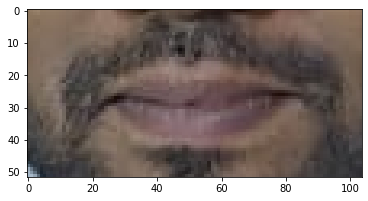

In [ ]:
imageMouth = get_mouth_region(face,"/content/gdrive/MyDrive/drowsy_detection/test_images/test_sleep_new.jpg")

In [ ]:
from numpy import *

def get_prediction_mouth(imageMouth,model):
    imageMouth = imageMouth.resize((256, 256), Image.BILINEAR)
    x = image.img_to_array(imageMouth)
    # Adding the fouth dimension, for number of images
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    predictions=new_model.predict(x)
    print(predictions)
    return reversed_dictionary.get(np.argmax(predictions))


In [ ]:
resultYawn = get_prediction_mouth(imageMouth,new_model)

[[0.56745964 0.2991411  0.0256931  0.10770624]]


In [ ]:
resultYawn

'Closed'